In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

import tensorflow as tf

2024-11-12 19:06:21.496841: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
## Adjust to where you have your datasets prepared with the 'Preparation.ipynb' notebook

StartPath = '../../groups/evocell/Octavio/CARE/'

number of training images:	 2880
number of validation images:	 320
image size (2D):		 (512, 512)
axes:				 SYXC
channels in / out:		 1 / 1


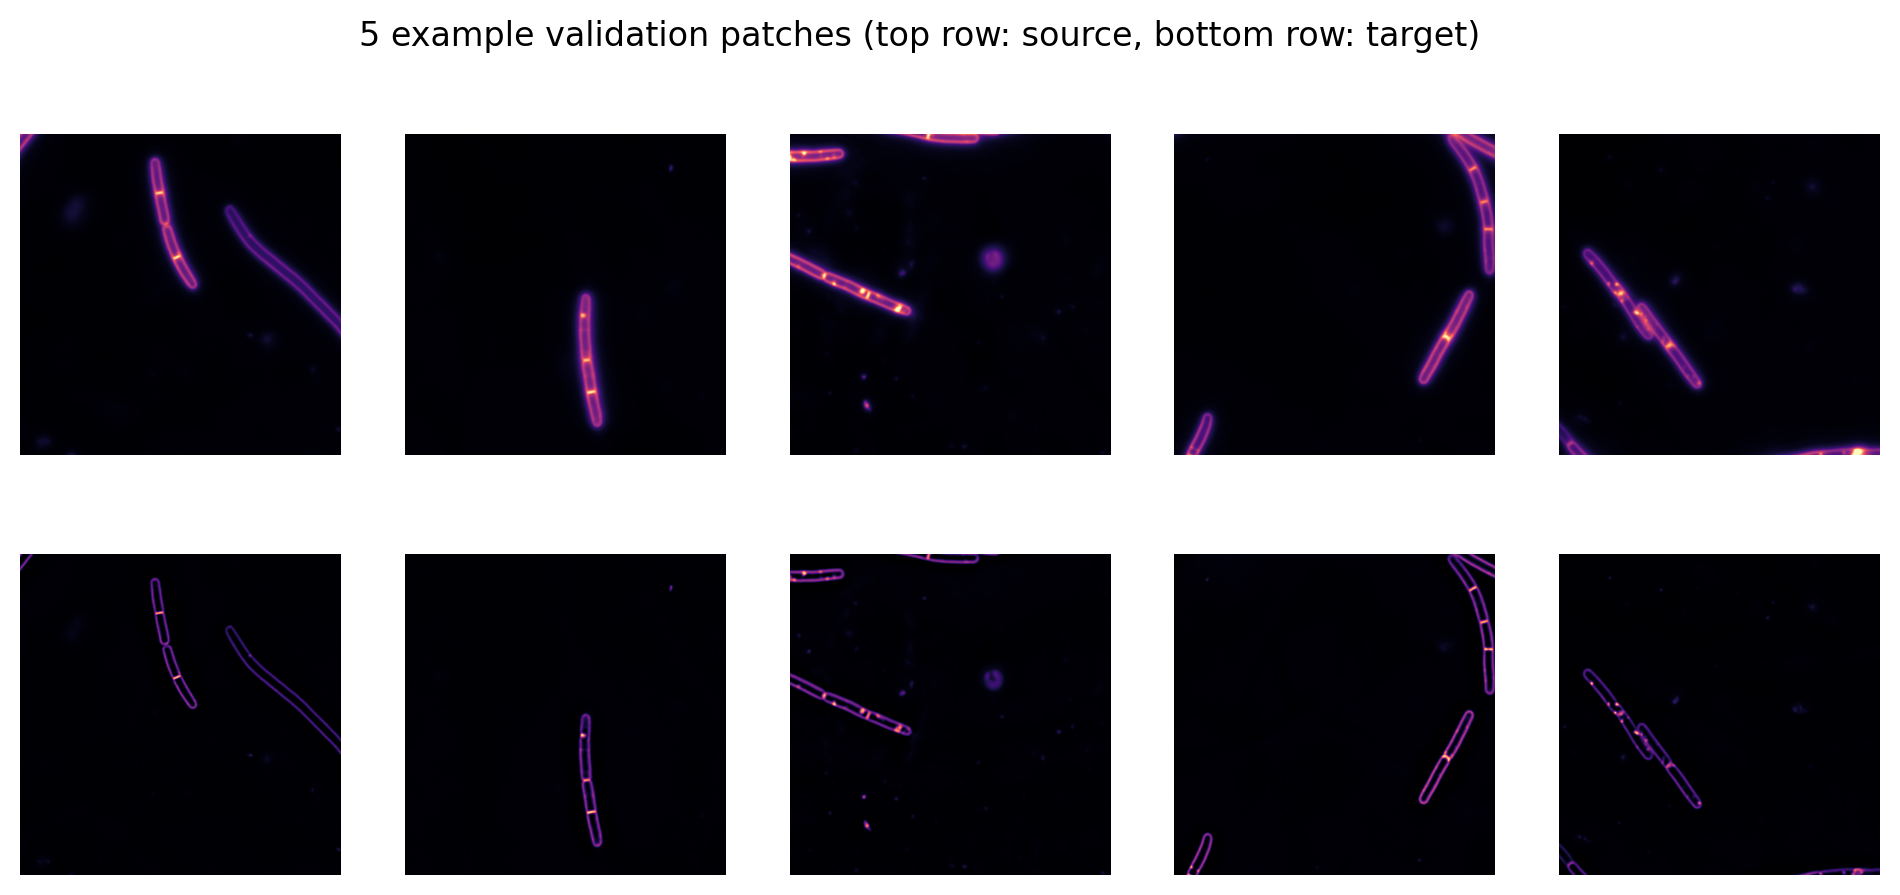

In [7]:
## Load and briefly inspect the data

(X,Y), (X_val,Y_val), axes = load_training_data(StartPath+'FM2FM/FM2FM.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [8]:
## Create the model configuration

config = Config(axes, n_channel_in, n_channel_out, unet_kern_size=3, 
                train_batch_size=16, train_steps_per_epoch=100, train_epochs=100)

model = CARE(config, 'CARE_FM2FM', basedir=StartPath+'models')

print(config)
vars(config)

/home/reyesmatte/mambaforge/envs/care/lib/python3.7/site-packages/csbdeep/models/base_model.py:149: UserWarning: output path for model already exists, files may be overwritten: /groups/evocell/Octavio/CARE/models/CARE_FM2FM
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=100, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [9]:
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
down_level_0_no_1 (Conv2D)      (None, None, None, 3 9248        down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
max_0 (MaxPooling2D)            (None, None, None, 3 0           down_level_0_no_1[0][0]          
____________________________________________________________________________________________

In [ ]:
## Train the model
## Here I specify the GPU using tensorflow, change the index accordingly

with tf.device('/device:GPU:7'):
    history = model.train(X,Y, validation_data=(X_val,Y_val))

In [ ]:
## Plot loss dyanmics during training

print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

In [ ]:
## export the model

model.export_TF()

In [ ]:
## I had some issues to check the performance right after the training, so I re-load the model after exporting

model = CARE(config=None, name='CARE_FM2FM', basedir=StartPath+'models')


In [ ]:
with tf.device('/device:GPU:7'):
    plt.figure(figsize=(20,12))
    _P = model.keras_model.predict(X_val[:5])
    if config.probabilistic:
        _P = _P[...,:(_P.shape[-1]//2)]
    plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
    plt.suptitle('5 example validation patches\n'      
                 'top row: input (source),  '          
                 'middle row: target (ground truth),  '
                 'bottom row: predicted from source');